# [Room Occupancy] Forecasting


### Prepare Workspace

In [83]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

sys.path.append('../code')
import prepare as pr

In [84]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [85]:
data_dir = 'C:/Users/makayser/Desktop/wattx_local/'
fn_prepared = 'prepared.csv'

### Prepare Data

In [86]:
df = pd.read_csv(data_dir + fn_prepared)
df['timestamp'] = pd.to_datetime(df['timestamp'])
tuples = list(zip(df['device'],df['timestamp']))
df.index = pd.MultiIndex.from_tuples(tuples, names=['device', 'timestamp'])

In [87]:
df.dtypes

device                       int64
timestamp           datetime64[ns]
device.1                     int64
device_activated             int64
timestamp.1                 object
occupied                     int64
weekday                      int64
timeperiod                   int64
time                        object
dtype: object

In [88]:
df.head()

device           timestamp  device.1  \
device timestamp                                                   
1      2016-07-25 16:00:00       1 2016-07-25 16:00:00         1   
       2016-07-25 17:00:00       1 2016-07-25 17:00:00         1   
       2016-07-25 18:00:00       1 2016-07-25 18:00:00         1   
       2016-07-25 19:00:00       1 2016-07-25 19:00:00         1   
       2016-07-25 20:00:00       1 2016-07-25 20:00:00         1   

                            device_activated          timestamp.1  occupied  \
device timestamp                                                              
1      2016-07-25 16:00:00                 6  2016-07-25 16:00:00         1   
       2016-07-25 17:00:00                 0  2016-07-25 17:00:00         0   
       2016-07-25 18:00:00                 0  2016-07-25 18:00:00         0   
       2016-07-25 19:00:00                 0  2016-07-25 19:00:00         0   
       2016-07-25 20:00:00                 0  2016-07-25 20:00:00         0   

                            weekday  timeperiod   time  
device timestamp                                        
1      2016-07-25 16:00:00        1           4  16:00  
       2016-07-25 17:00:00        1           4  17:00  
       2016-07-25 18:00:00        1           4  18:00  
       2016-07-25 19:00:00        1           4  19:00  
       2016-07-25 20:00:00        1           0  20:00

## Univariate Forecasting

In [53]:
def train_test(data, device_id, column='device_activated', cv=False):
    _data = data[data.index.get_level_values('device') == device_id][column]
    _data = pr.format_for_prophet(_data)
    fb_train, fb_valid = pr.split(_data, split=0.9)
    #Train
    m = Prophet(yearly_seasonality=False).fit(fb_train)
    # Score
    future = m.make_future_dataframe(periods=24, freq='H')
    future['floor'] = 0
    fcst = m.predict(future)
    # Evaluate
    if not cv:
        fig = m.plot(fcst)
    y_hat = fcst['yhat'].tail(24).apply(lambda x: translate_score(x)).values
    y_true = fb_valid['y'].head(24).apply(lambda x: translate_score(x)).values
    pr, re, fs, _ = precision_recall_fscore_support(y_true, y_hat, average='weighted')
    print(f'[INFO] Results \n\t Precision:\t {pr}')
    print(f'\t Recall:\t {re}')
    print(f'\t F1 Score:\t {fs}')
    
    if cv:
        # Cross Validation
        df_cv = cross_validation(m, horizon='24 hours')
        df_p = performance_metrics(df_cv)
        print(df_p.head(5))
        fig3 = plot_cross_validation_metric(df_cv, metric='rmse')
    return fcst['yhat'].tail(24).values, y_true
    

[INFO] Results 
	 Precision:	 1.0
	 Recall:	 1.0
	 F1 Score:	 1.0


INFO:fbprophet:Making 51 forecasts with cutoffs between 2016-08-01 23:00:00 and 2016-08-26 23:00:00
INFO:fbprophet:Skipping MAPE because y close to 0


   horizon       mse      rmse       mae  coverage
0 03:00:00  0.083985  0.289802  0.245382  0.781099
1 04:00:00  0.084113  0.290023  0.247370  0.779331
2 05:00:00  0.096617  0.310833  0.258869  0.740116
3 06:00:00  0.079081  0.281213  0.226261  0.817101
4 07:00:00  0.055749  0.236113  0.189187  0.907586


(array([-0.26379966, -0.24177035, -0.24290746, -0.27702511, -0.29845407,
        -0.2376419 , -0.06882412,  0.15296754,  0.32780534,  0.39188998,
         0.36913326,  0.34338003,  0.37588341,  0.44544055,  0.46783501,
         0.37619177,  0.18658012, -0.01165301, -0.12951668, -0.14613523,
        -0.11080389, -0.08533571, -0.08800502, -0.0920123 ]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0], dtype=int64))

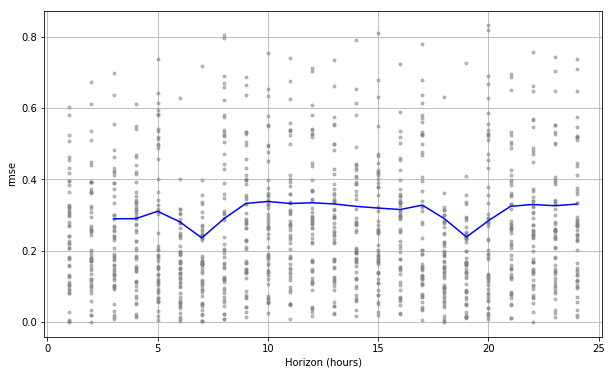

In [54]:
train_test(df, 1, column='occupied', cv=True)

C:\Users\makayser\.conda\envs\opc\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[INFO] Results 
	 Precision:	 1.0
	 Recall:	 0.5833333333333334
	 F1 Score:	 0.7368421052631579


INFO:fbprophet:Making 51 forecasts with cutoffs between 2016-08-01 23:00:00 and 2016-08-26 23:00:00
INFO:fbprophet:Skipping MAPE because y close to 0


   horizon       mse      rmse       mae  coverage
0 03:00:00  2.666051  1.632805  1.253311  0.761170
1 04:00:00  2.740190  1.655352  1.282857  0.736901
2 05:00:00  2.477146  1.573895  1.216688  0.769688
3 06:00:00  1.575161  1.255054  0.946809  0.881228
4 07:00:00  0.818380  0.904643  0.710671  0.971070


(array([-1.24656666, -1.03075746, -0.95599587, -1.15848235, -1.39706945,
        -1.23083051, -0.45254498,  0.65302394,  1.50942424,  1.7436867 ,
         1.50869955,  1.31554892,  1.52753169,  1.99884703,  2.20674493,
         1.75257394,  0.75400926, -0.24058223, -0.72449607, -0.63951493,
        -0.34865816, -0.23908662, -0.36722301, -0.48401524]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0], dtype=int64))

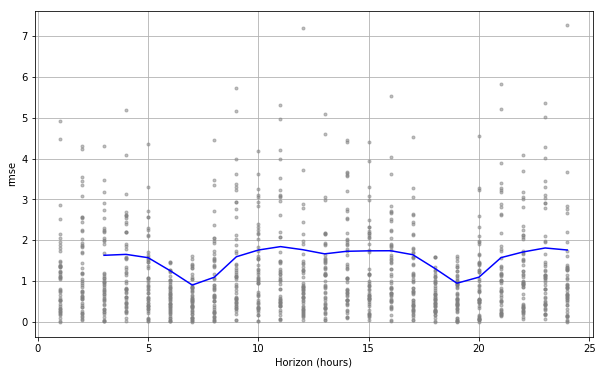

In [55]:
train_test(df, 1, column='device_activated', cv=True)

[INFO] Results 
	 Precision:	 0.9017857142857143
	 Recall:	 0.875
	 F1 Score:	 0.8743478260869565


INFO:fbprophet:Making 95 forecasts with cutoffs between 2016-07-08 12:00:00 and 2016-08-24 12:00:00
INFO:fbprophet:Skipping MAPE because y close to 0


   horizon       mse      rmse       mae  coverage
0 03:00:00  0.089046  0.298405  0.243247  0.811404
1 04:00:00  0.094688  0.307714  0.252723  0.771053
2 05:00:00  0.106019  0.325606  0.269231  0.737719
3 06:00:00  0.109411  0.330774  0.270690  0.762281
4 07:00:00  0.112398  0.335259  0.264779  0.732456


(array([0.79156057, 0.85147725, 0.8277577 , 0.69475825, 0.49522292,
        0.3093619 , 0.19890114, 0.1721439 , 0.19315684, 0.21863023,
        0.22688379, 0.21918624, 0.20394209, 0.18751831, 0.1806071 ,
        0.20564278, 0.28671106, 0.42427837, 0.57992703, 0.69371528,
        0.72707398, 0.69547053, 0.65816226, 0.66853114]),
 array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1], dtype=int64))

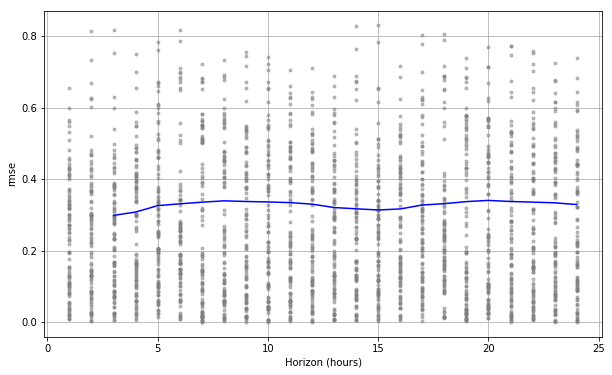

In [56]:
train_test(df, 2, column='occupied', cv=True)

C:\Users\makayser\.conda\envs\opc\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[INFO] Results 
	 Precision:	 0.29340277777777773
	 Recall:	 0.5416666666666666
	 F1 Score:	 0.38063063063063063


INFO:fbprophet:Making 95 forecasts with cutoffs between 2016-07-08 12:00:00 and 2016-08-24 12:00:00
INFO:fbprophet:Skipping MAPE because y close to 0


   horizon       mse      rmse       mae  coverage
0 03:00:00  8.395215  2.897450  2.181320  0.774561
1 04:00:00  8.859830  2.976547  2.252324  0.750000
2 05:00:00  6.765152  2.600991  1.959106  0.823684
3 06:00:00  4.159644  2.039520  1.555064  0.910526
4 07:00:00  7.771372  2.787718  1.899832  0.842105


(array([6.72915768, 7.49607201, 7.13386149, 5.60890705, 3.69075627,
        2.29787455, 1.80465342, 1.9041601 , 2.05439591, 2.00207304,
        1.88367283, 1.89631544, 1.97855626, 1.88664891, 1.57563923,
        1.41931794, 1.94368891, 3.27506906, 4.8652999 , 5.84670941,
        5.75955576, 4.98448025, 4.43617959, 4.75193509]),
 array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1], dtype=int64))

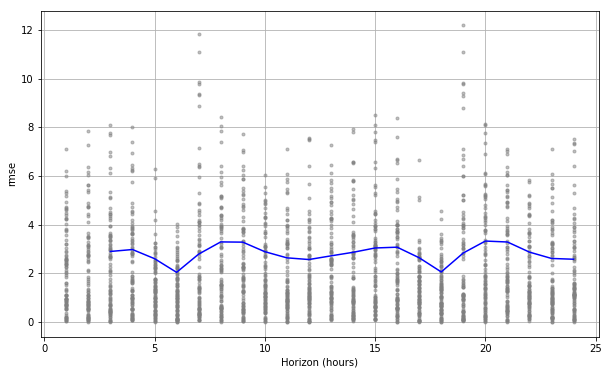

In [57]:
train_test(df, 2, column='device_activated', cv=True)

C:\Users\makayser\.conda\envs\opc\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[INFO] Results 
	 Precision:	 0.390625
	 Recall:	 0.625
	 F1 Score:	 0.4807692307692308


INFO:fbprophet:Making 95 forecasts with cutoffs between 2016-07-08 10:00:00 and 2016-08-24 10:00:00
INFO:fbprophet:Skipping MAPE because y close to 0


   horizon       mse      rmse       mae  coverage
0 03:00:00  0.117053  0.342130  0.266506  0.657895
1 04:00:00  0.112403  0.335266  0.258444  0.683333
2 05:00:00  0.104647  0.323492  0.241489  0.766667
3 06:00:00  0.095117  0.308411  0.219108  0.844737
4 07:00:00  0.074342  0.272657  0.183439  0.905263


(array([ 0.37513132,  0.38206705,  0.3814342 ,  0.34578847,  0.26869091,
         0.17678134,  0.10854487,  0.08082485,  0.07632133,  0.06397519,
         0.03105776, -0.00557655, -0.01987635, -0.00672515,  0.01039742,
         0.00359478, -0.02722873, -0.04770027, -0.01723022,  0.07315136,
         0.18937352,  0.2808273 ,  0.32028171,  0.32033356]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0], dtype=int64))

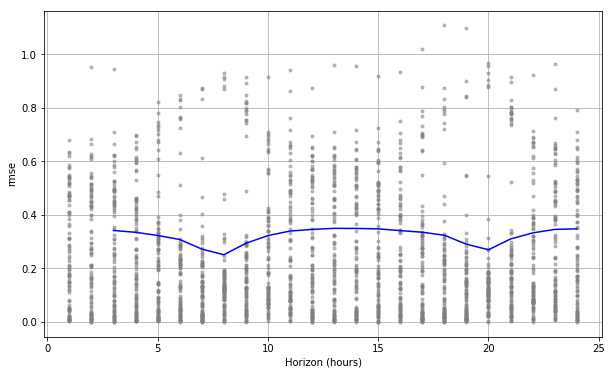

In [58]:
train_test(df, 3, column='occupied', cv=True)

[INFO] Results 
	 Precision:	 0.8333333333333334
	 Recall:	 0.8333333333333334
	 F1 Score:	 0.8333333333333334


INFO:fbprophet:Making 95 forecasts with cutoffs between 2016-07-08 10:00:00 and 2016-08-24 10:00:00
INFO:fbprophet:Skipping MAPE because y close to 0


   horizon       mse      rmse       mae  coverage
0 03:00:00  1.930547  1.389441  0.974808  0.842105
1 04:00:00  2.446517  1.564135  1.079092  0.815789
2 05:00:00  2.886195  1.698881  1.143223  0.802632
3 06:00:00  2.123700  1.457292  0.952866  0.862281
4 07:00:00  1.127536  1.061855  0.705626  0.928947


(array([ 1.44120814,  1.51919751,  1.60303376,  1.57408552,  1.33749957,
         0.93605394,  0.53784187,  0.30322331,  0.25570125,  0.27848834,
         0.23631146,  0.1015712 , -0.035953  , -0.07777201, -0.02766546,
         0.01048281, -0.05391524, -0.19056681, -0.26007926, -0.13951575,
         0.15918333,  0.49417922,  0.71757988,  0.79693777]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0], dtype=int64))

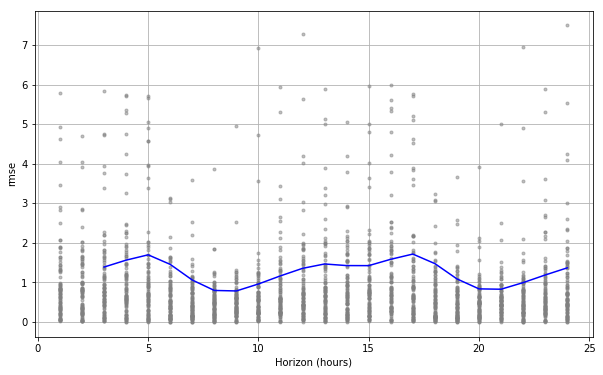

In [59]:
train_test(df, 3, column='device_activated', cv=True)

C:\Users\makayser\.conda\envs\opc\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[INFO] Results 
	 Precision:	 0.9184027777777778
	 Recall:	 0.9583333333333334
	 F1 Score:	 0.9379432624113475


INFO:fbprophet:Making 95 forecasts with cutoffs between 2016-07-08 13:00:00 and 2016-08-24 13:00:00
INFO:fbprophet:Skipping MAPE because y close to 0


   horizon       mse      rmse       mae  coverage
0 03:00:00  0.096741  0.311033  0.262648  0.792982
1 04:00:00  0.088784  0.297967  0.247291  0.792982
2 05:00:00  0.069337  0.263320  0.213513  0.850877
3 06:00:00  0.059038  0.242977  0.200606  0.880702
4 07:00:00  0.072886  0.269974  0.228280  0.824561


(array([ 0.39070401,  0.39309331,  0.3054347 ,  0.14619752, -0.0153565 ,
        -0.11597824, -0.14452585, -0.13799232, -0.13803514, -0.15421311,
        -0.16780585, -0.16519092, -0.15961294, -0.17533315, -0.21154927,
        -0.22859274, -0.17801876, -0.05155746,  0.1002044 ,  0.20303625,
         0.21963652,  0.1796626 ,  0.14957099,  0.16895148]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0], dtype=int64))

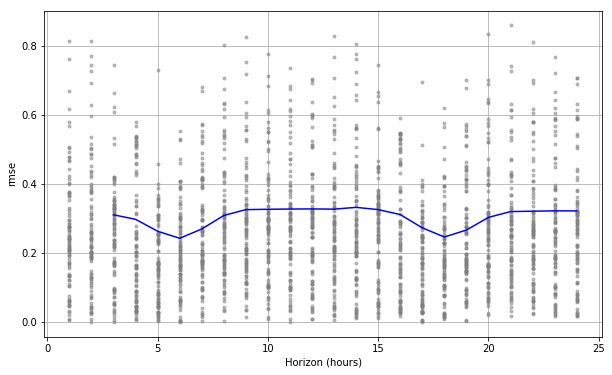

In [60]:
train_test(df, 4, column='occupied', cv=True)

[INFO] Results 
	 Precision:	 0.9078947368421052
	 Recall:	 0.75
	 F1 Score:	 0.8214285714285713


INFO:fbprophet:Making 95 forecasts with cutoffs between 2016-07-08 13:00:00 and 2016-08-24 13:00:00
INFO:fbprophet:Skipping MAPE because y close to 0


   horizon       mse      rmse       mae  coverage
0 03:00:00  1.431296  1.196368  0.946171  0.850000
1 04:00:00  1.232466  1.110165  0.826035  0.884211
2 05:00:00  0.947954  0.973629  0.702574  0.928947
3 06:00:00  0.819536  0.905282  0.694403  0.948246
4 07:00:00  0.938468  0.968746  0.772057  0.931579


(array([ 1.0336948 ,  1.02686501,  0.69443608,  0.13327846, -0.38670577,
        -0.65267738, -0.66924557, -0.60958665, -0.62606276, -0.71715975,
        -0.77359463, -0.73409281, -0.67049592, -0.70439621, -0.84466209,
        -0.92982759, -0.758511  , -0.29372733,  0.26411001,  0.62493056,
         0.65189089,  0.47225879,  0.34732871,  0.42076161]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0], dtype=int64))

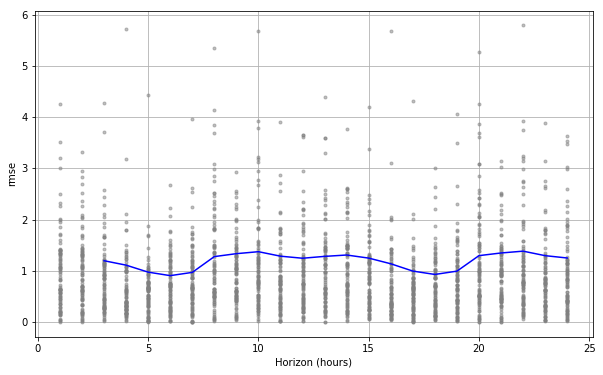

In [61]:
train_test(df, 4, column='device_activated', cv=True)

C:\Users\makayser\.conda\envs\opc\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[INFO] Results 
	 Precision:	 1.0
	 Recall:	 0.7916666666666666
	 F1 Score:	 0.8837209302325583


INFO:fbprophet:Making 95 forecasts with cutoffs between 2016-07-08 11:00:00 and 2016-08-24 11:00:00
INFO:fbprophet:Skipping MAPE because y close to 0


   horizon       mse      rmse       mae  coverage
0 03:00:00  0.103636  0.321926  0.273261  0.757895
1 04:00:00  0.102388  0.319981  0.269404  0.757018
2 05:00:00  0.101289  0.318259  0.267900  0.750000
3 06:00:00  0.096849  0.311206  0.256027  0.737719
4 07:00:00  0.089042  0.298399  0.232224  0.802632


(array([0.56904457, 0.59825301, 0.63577638, 0.61877424, 0.5151761 ,
        0.35586293, 0.20957547, 0.12652508, 0.10398444, 0.10232478,
        0.08977471, 0.06897739, 0.06166958, 0.07351054, 0.0813663 ,
        0.0595736 , 0.01736394, 0.0039155 , 0.06853491, 0.21084654,
        0.3707423 , 0.47265106, 0.48623289, 0.44759095]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0], dtype=int64))

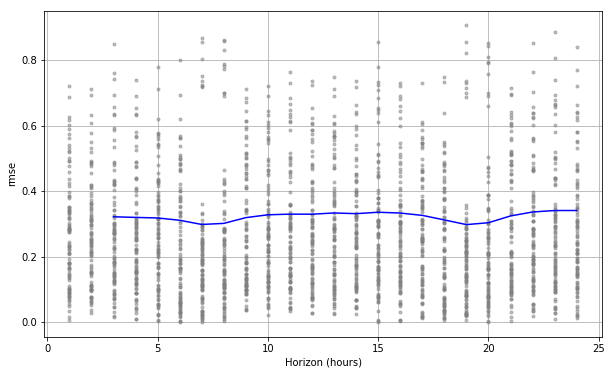

In [62]:
train_test(df, 5, column='occupied', cv=True)

C:\Users\makayser\.conda\envs\opc\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[INFO] Results 
	 Precision:	 1.0
	 Recall:	 0.5
	 F1 Score:	 0.6666666666666666


INFO:fbprophet:Making 95 forecasts with cutoffs between 2016-07-08 11:00:00 and 2016-08-24 11:00:00
INFO:fbprophet:Skipping MAPE because y close to 0


   horizon       mse      rmse       mae  coverage
0 03:00:00  2.873224  1.695059  1.304042  0.766667
1 04:00:00  3.216585  1.793484  1.408329  0.713158
2 05:00:00  3.126388  1.768160  1.400744  0.701754
3 06:00:00  2.635803  1.623516  1.254136  0.764912
4 07:00:00  1.825789  1.351218  1.006375  0.864912


(array([ 2.08263594,  2.25336438,  2.57298427,  2.61598376,  2.14118563,
         1.32087152,  0.58535119,  0.246686  ,  0.26324881,  0.34902842,
         0.28692978,  0.1197969 ,  0.04246856,  0.13808963,  0.26009392,
         0.19757656, -0.05060063, -0.20054903,  0.0780643 ,  0.82322813,
         1.6827579 ,  2.18229351,  2.12700489,  1.76044673]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0], dtype=int64))

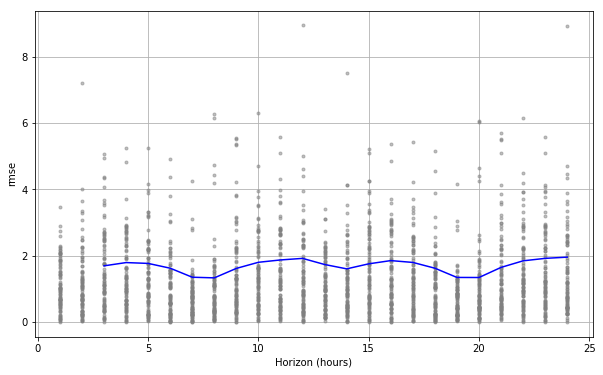

In [63]:
train_test(df, 5, column='device_activated', cv=True)

[INFO] Results 
	 Precision:	 0.9166666666666666
	 Recall:	 0.9166666666666666
	 F1 Score:	 0.9166666666666666


INFO:fbprophet:Making 95 forecasts with cutoffs between 2016-07-08 13:00:00 and 2016-08-24 13:00:00
INFO:fbprophet:Skipping MAPE because y close to 0


   horizon       mse      rmse       mae  coverage
0 03:00:00  0.097501  0.312251  0.240506  0.850000
1 04:00:00  0.104504  0.323271  0.267951  0.807018
2 05:00:00  0.136434  0.369369  0.322034  0.637719
3 06:00:00  0.144877  0.380627  0.335600  0.598246
4 07:00:00  0.129263  0.359532  0.309873  0.718421


(array([0.86372542, 0.86528483, 0.80633218, 0.68130776, 0.50592609,
        0.31922787, 0.17323624, 0.10728305, 0.12110886, 0.17016445,
        0.19405178, 0.16158051, 0.09772432, 0.06810803, 0.12990553,
        0.28648175, 0.4814278 , 0.63633476, 0.702268  , 0.68627152,
        0.63691564, 0.60546496, 0.61397684, 0.64944209]),
 array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1], dtype=int64))

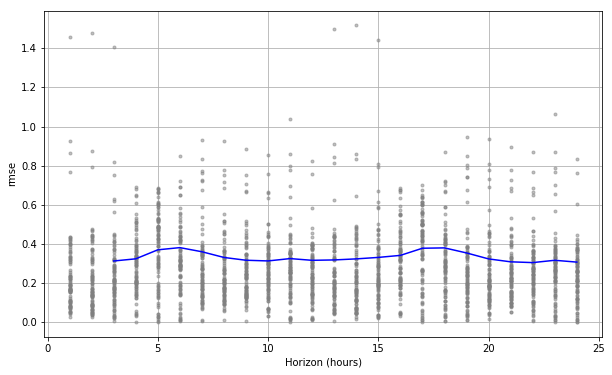

In [64]:
train_test(df, 6, column='occupied', cv=True)

[INFO] Results 
	 Precision:	 0.8529411764705882
	 Recall:	 0.7916666666666666
	 F1 Score:	 0.7822141560798549


INFO:fbprophet:Making 95 forecasts with cutoffs between 2016-07-08 13:00:00 and 2016-08-24 13:00:00
INFO:fbprophet:Skipping MAPE because y close to 0


   horizon       mse      rmse       mae  coverage
0 03:00:00  2.500126  1.581179  1.212562  0.814912
1 04:00:00  2.050896  1.432095  1.133336  0.846491
2 05:00:00  1.661480  1.288984  1.044890  0.858772
3 06:00:00  2.037480  1.427403  1.143610  0.830702
4 07:00:00  2.660307  1.631045  1.316649  0.801754


(array([4.13650413, 3.86338329, 3.12215212, 2.17437735, 1.35644981,
        0.84233149, 0.59011801, 0.47220762, 0.41968332, 0.43453752,
        0.49472769, 0.50297652, 0.37383351, 0.17813902, 0.16601399,
        0.58982037, 1.45867096, 2.45980859, 3.15549174, 3.31091006,
        3.07022262, 2.81792492, 2.84067615, 3.08428456]),
 array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1], dtype=int64))

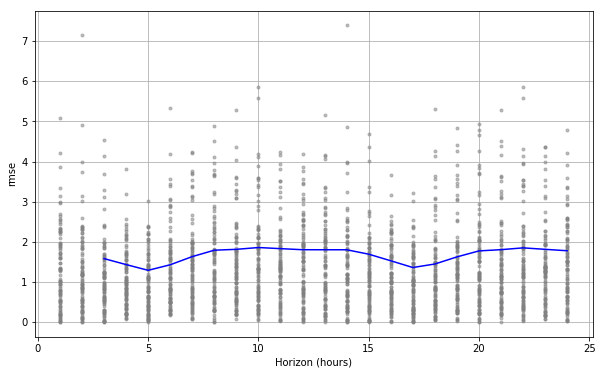

In [65]:
train_test(df, 6, column='device_activated', cv=True)

[INFO] Results 
	 Precision:	 1.0
	 Recall:	 1.0
	 F1 Score:	 1.0


INFO:fbprophet:Making 85 forecasts with cutoffs between 2016-07-11 19:00:00 and 2016-08-22 19:00:00
INFO:fbprophet:Skipping MAPE because y close to 0


   horizon       mse      rmse       mae  coverage
0 03:00:00  0.047144  0.217127  0.132851  0.934314
1 04:00:00  0.054656  0.233786  0.136975  0.926471
2 05:00:00  0.047118  0.217067  0.126334  0.934314
3 06:00:00  0.044553  0.211075  0.127613  0.932353
4 07:00:00  0.061284  0.247556  0.154319  0.889216


(array([-0.01557256, -0.00099137, -0.00345905, -0.01769576, -0.02413393,
        -0.0132791 ,  0.00306858,  0.00551728, -0.00934719, -0.0215157 ,
        -0.00579518,  0.04179592,  0.09679545,  0.12729741,  0.12374281,
         0.10806715,  0.11210842,  0.14537172,  0.18347274,  0.18926267,
         0.14722463,  0.07877909,  0.0242795 ,  0.00901626]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0], dtype=int64))

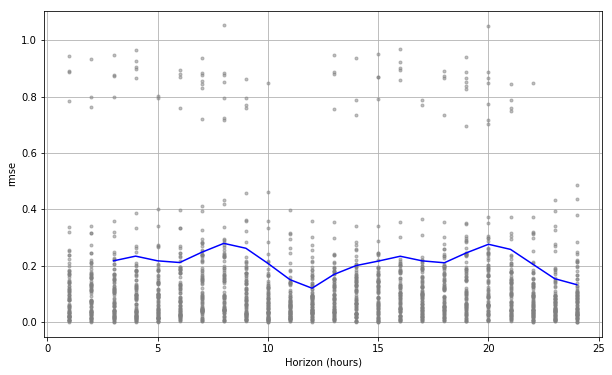

In [66]:
train_test(df, 7, column='occupied', cv=True)

C:\Users\makayser\.conda\envs\opc\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[INFO] Results 
	 Precision:	 1.0
	 Recall:	 0.9583333333333334
	 F1 Score:	 0.9787234042553191


INFO:fbprophet:Making 85 forecasts with cutoffs between 2016-07-11 19:00:00 and 2016-08-22 19:00:00
INFO:fbprophet:Skipping MAPE because y close to 0


   horizon       mse      rmse       mae  coverage
0 03:00:00  0.283762  0.532693  0.382444  0.968627
1 04:00:00  0.428550  0.654638  0.415227  0.959804
2 05:00:00  0.420483  0.648447  0.403024  0.959804
3 06:00:00  0.336351  0.579958  0.388243  0.967647
4 07:00:00  0.350641  0.592149  0.410383  0.959804


(array([-0.05930587, -0.01584855, -0.02311937, -0.05647377, -0.06332796,
        -0.02490161,  0.02297062,  0.03126267, -0.00314736, -0.02483649,
         0.02934766,  0.1651377 ,  0.31791493,  0.40820085,  0.41320049,
         0.38423112,  0.39198017,  0.45279697,  0.50891418,  0.48332336,
         0.35681995,  0.19246972,  0.08340386,  0.07366873]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0], dtype=int64))

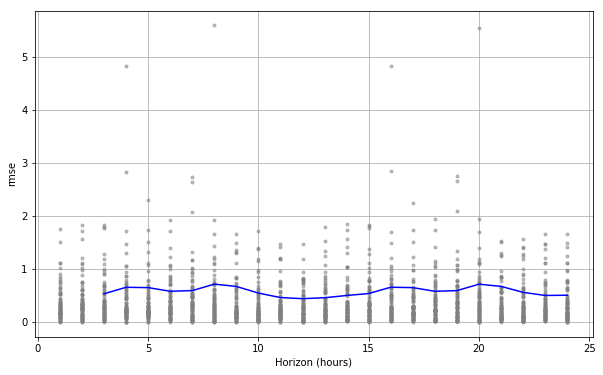

In [67]:
train_test(df, 7, column='device_activated', cv=True)